# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from tqdm import tqdm
from skimage.transform import resize
import torchvision.utils as vutils
from torchvision import transforms
from mpl_toolkits.axes_grid1 import ImageGrid

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Preprocess and Save

### Load Preporcessed Dataset

In [3]:
#dataroot = "/work/kabaeuer/AA_Experiment/bilinear_SN3/log/example/images_100"
#dataset = dset.ImageFolder(root=dataroot)
#images = []
#for rost in range(len(dataset)):
#    print(rost)
#    for row in range(1,33):
#        for i in range(1,9):
#            images.append(dataset[rost][0].crop((2*i+32*(i-1),2*row+32*(row-1),2*i+32*(i),2*row+32*(row))))
#save_obj(images,"/work/kabaeuer/AA_Experiment/bilinear_SN3/log/example/all_images_100")

In [4]:
# loading images
images_l = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN3/log/example/all_images")

39936


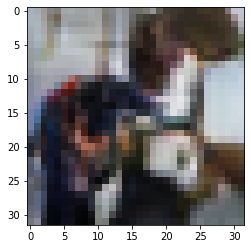

In [5]:
# Example image
print(len(images_l))
imgplot = plt.imshow(images_l[0])
plt.show()

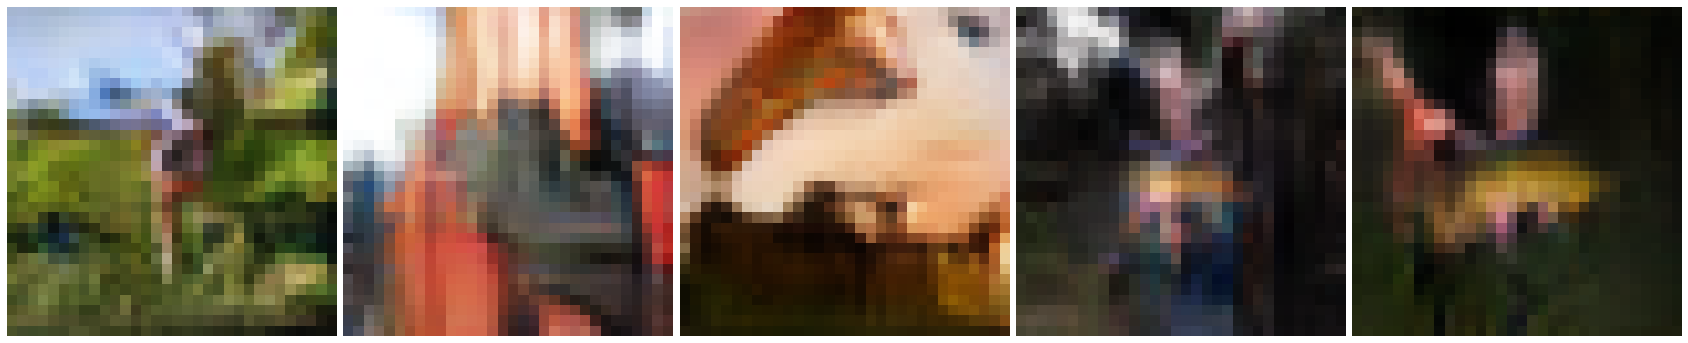

In [6]:
im1 = images_l[123]
im2 = images_l[4]
im3 = images_l[20]
im4 = images_l[9]
im5 = images_l[3]

fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [im1, im2, im3, im4, im5]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_axis_off()
plt.show()

## Real Images

In [7]:
# create cifar order
#transforms_list_first = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
#first = dset.ImageFolder('/work/kabaeuer/data/imagenette2/', transform=transforms_list_first)
#data_loader_first = torch.utils.data.DataLoader(dataset=first, batch_size=1, num_workers=0)
#pbar = tqdm(enumerate(data_loader_first), total=len(data_loader_first))
#for batch_idx, (data, target) in pbar:
#    vutils.save_image(data.detach(),'/work/kabaeuer/data/imagenette_32/imgs/'+ str(batch_idx)+'.png',normalize=True)

In [8]:
#import os
#import imageio
#path = "/work/kabaeuer/data/imagenette_32/imgs"
#i=0
#list_dir=[int(file.split(".")[0]) for file in os.listdir(path)]
#list_dir.sort()
#print(len(list_dir))
#images_real = []
#for fname in list_dir:    
#    img = imageio.imread(path + '/' + str(fname)+".png")
#    images_real.append(img)
#save_obj(images_real,'/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images')

In [9]:
images_real = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images")

13260


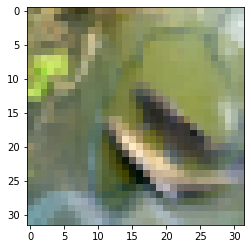

In [10]:
# Example image
print(len(images_real))
imgplot = plt.imshow(images_real[0])
plt.show()

# Analyzing Images

## Creating FFT

In [11]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

In [12]:
# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

### Generated Images

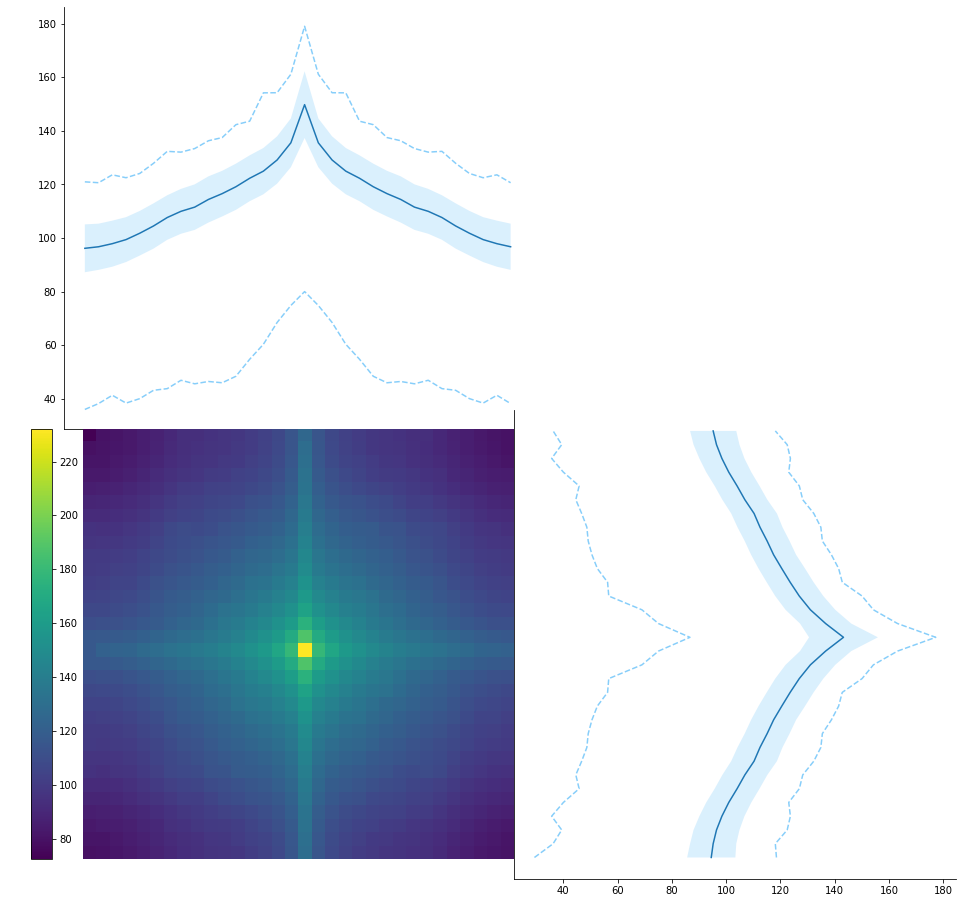

In [13]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g)

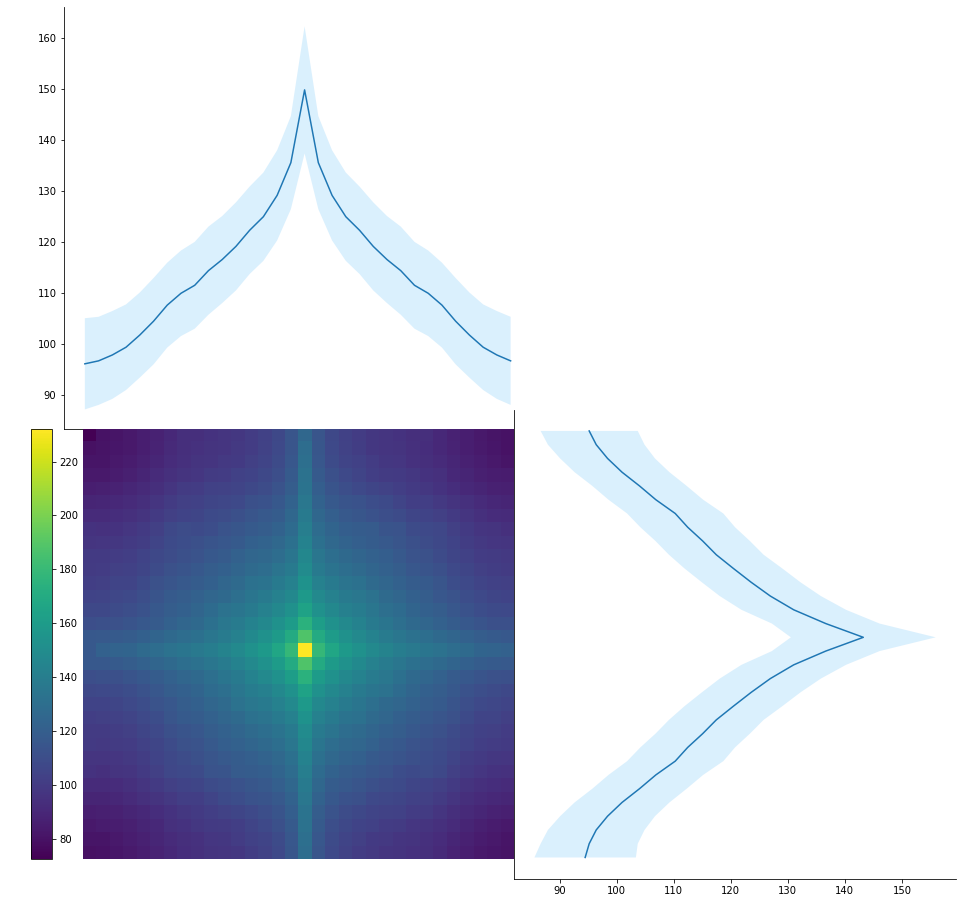

In [14]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Normalized

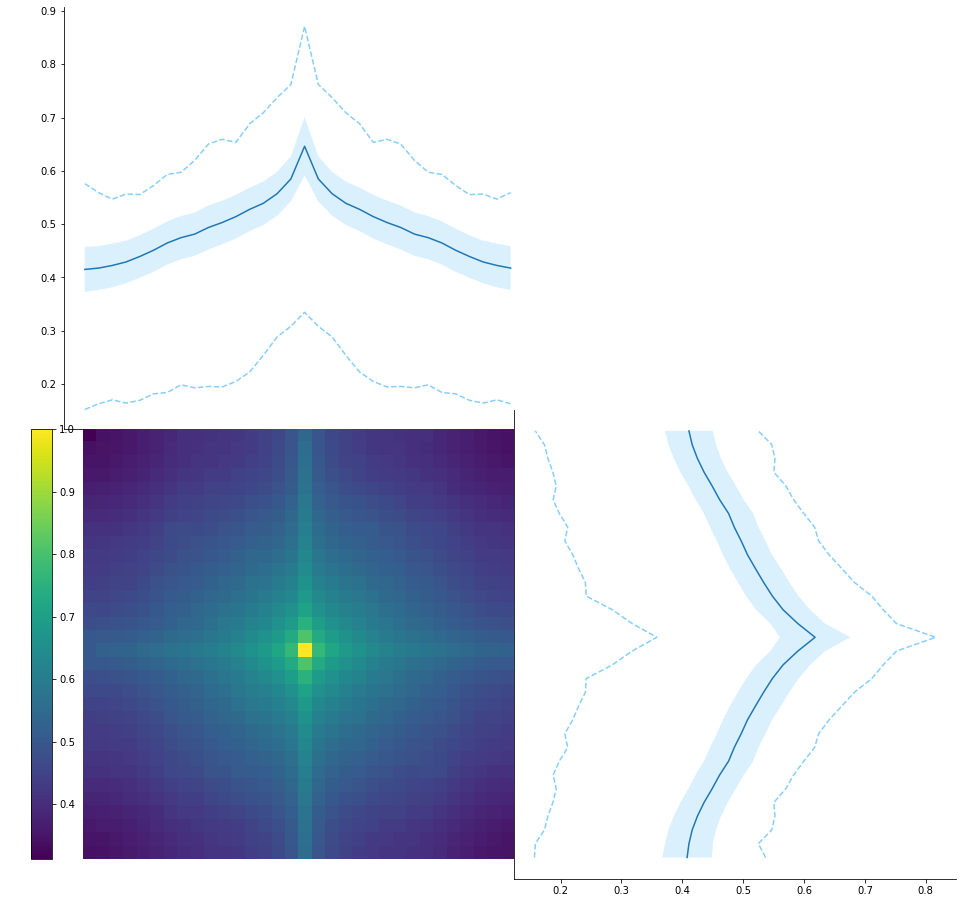

In [15]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,True)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = True)

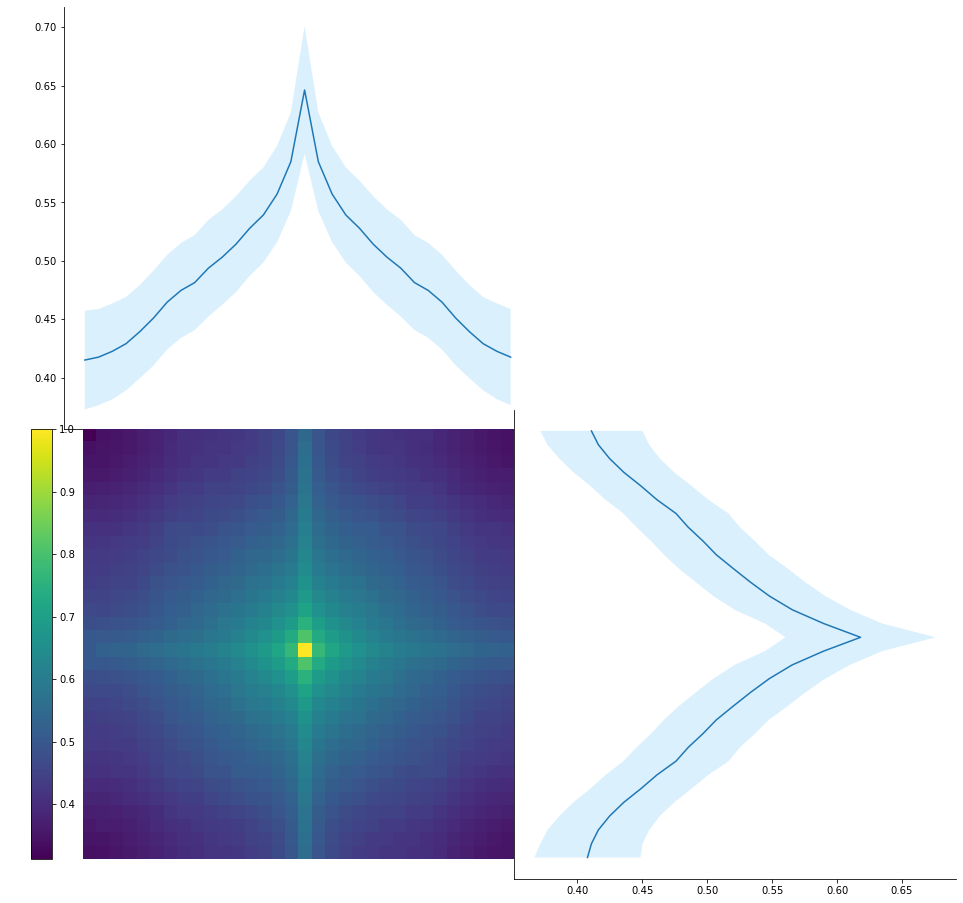

In [16]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l, True)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Real Images

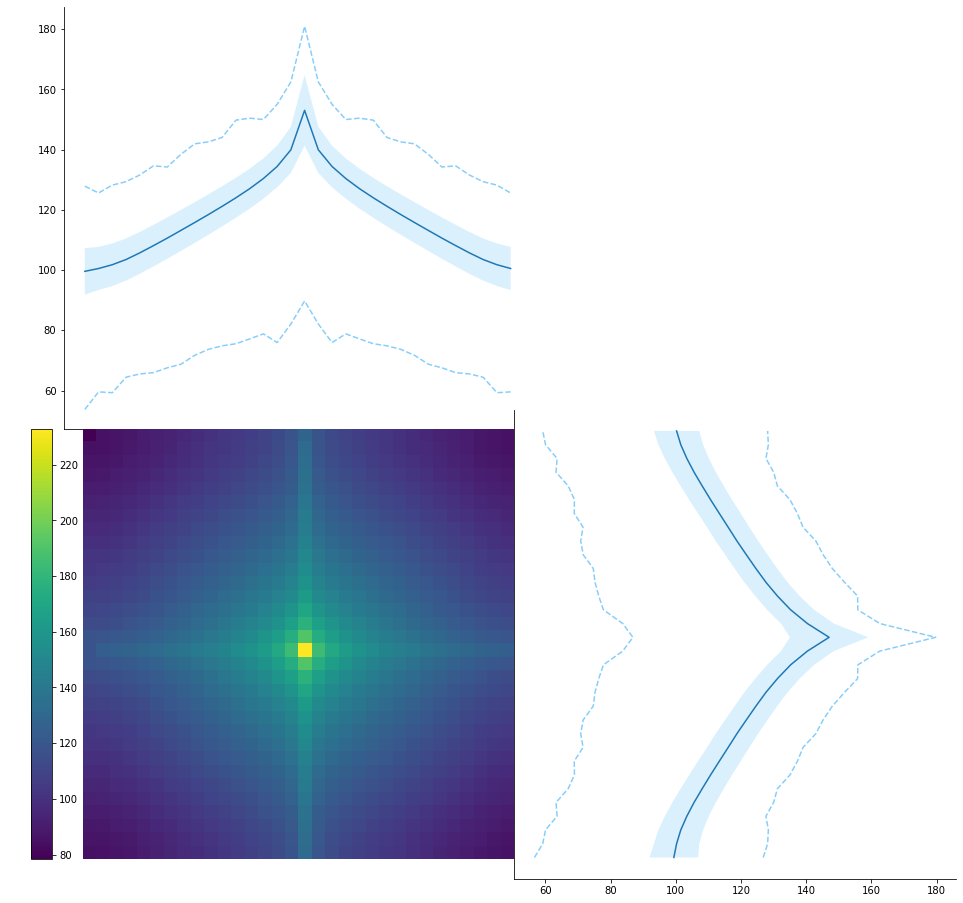

In [17]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

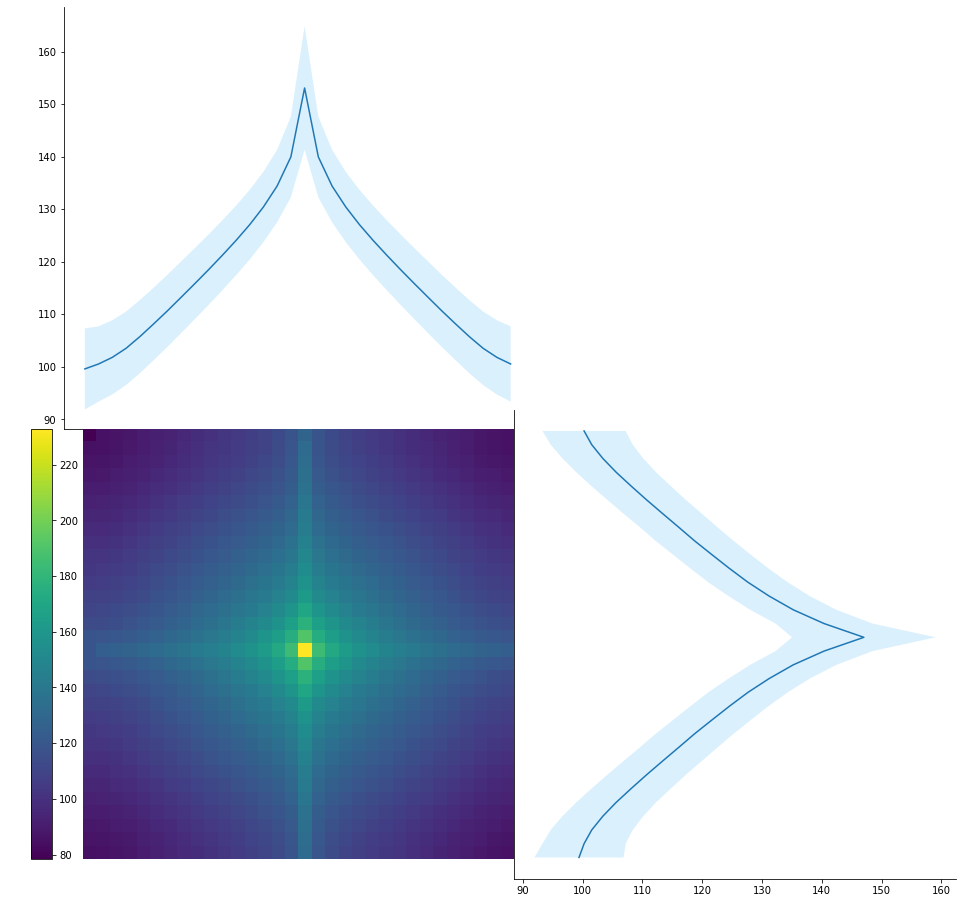

In [18]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Normalized

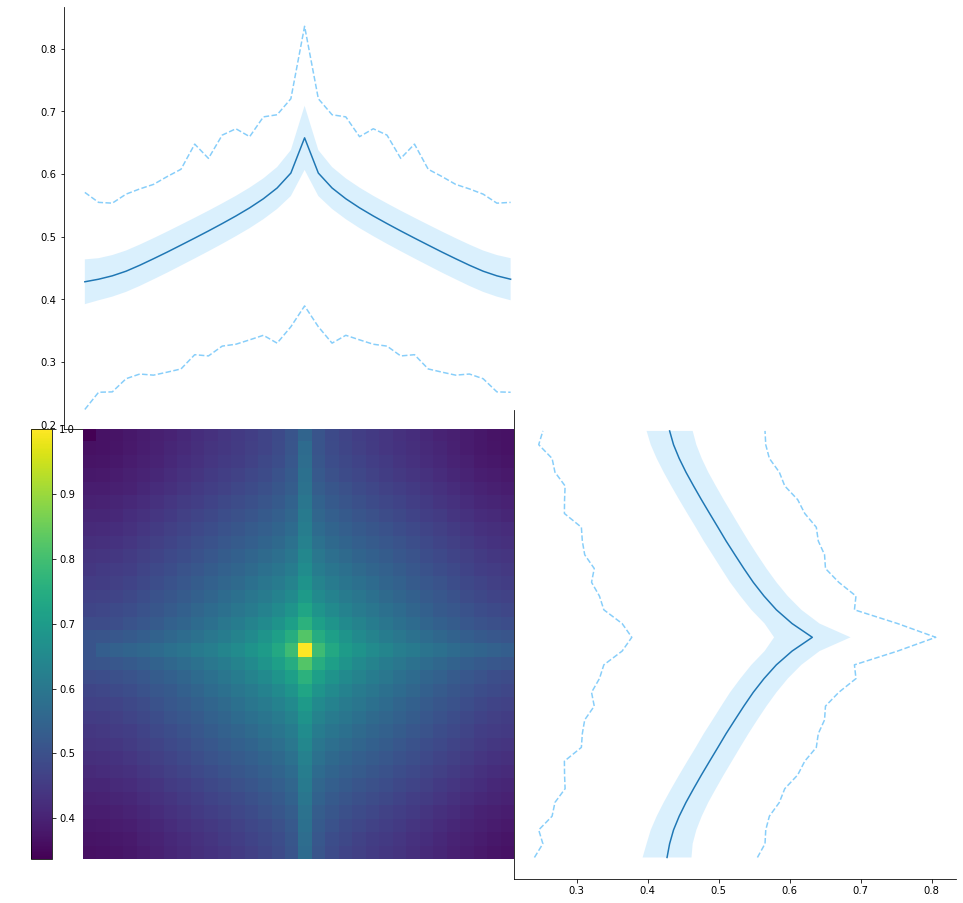

In [19]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real, True)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

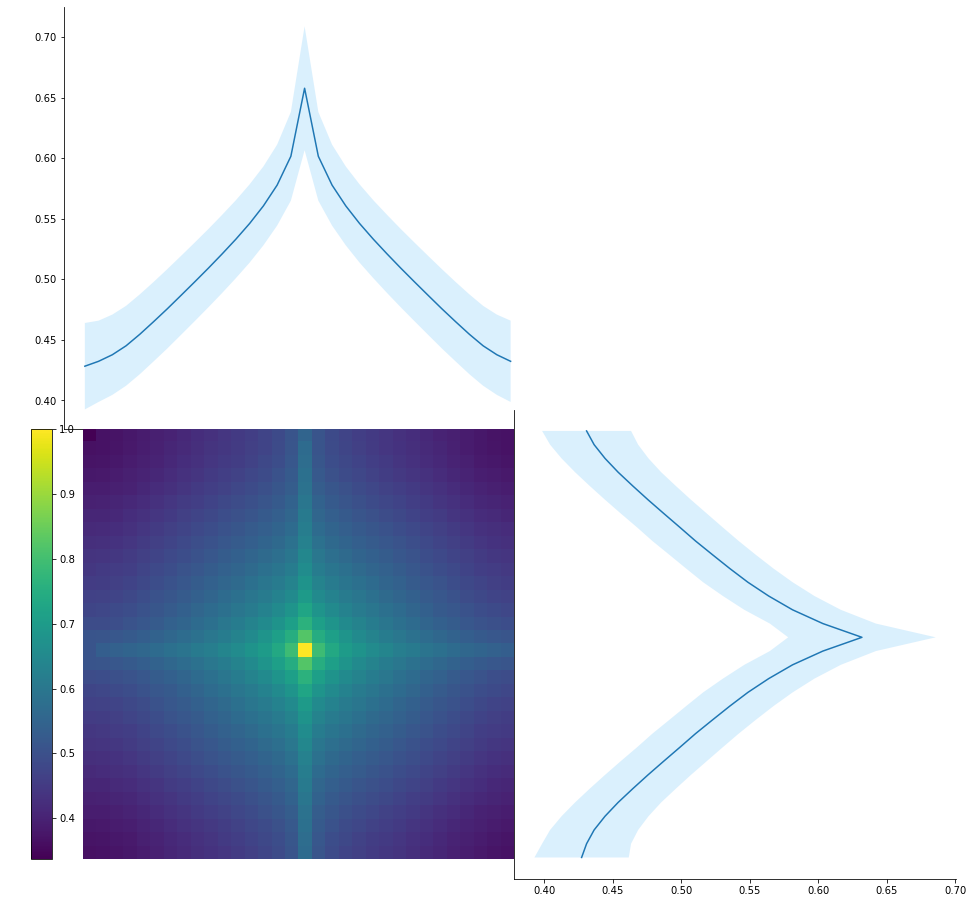

In [20]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real, True)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Real vs Fake

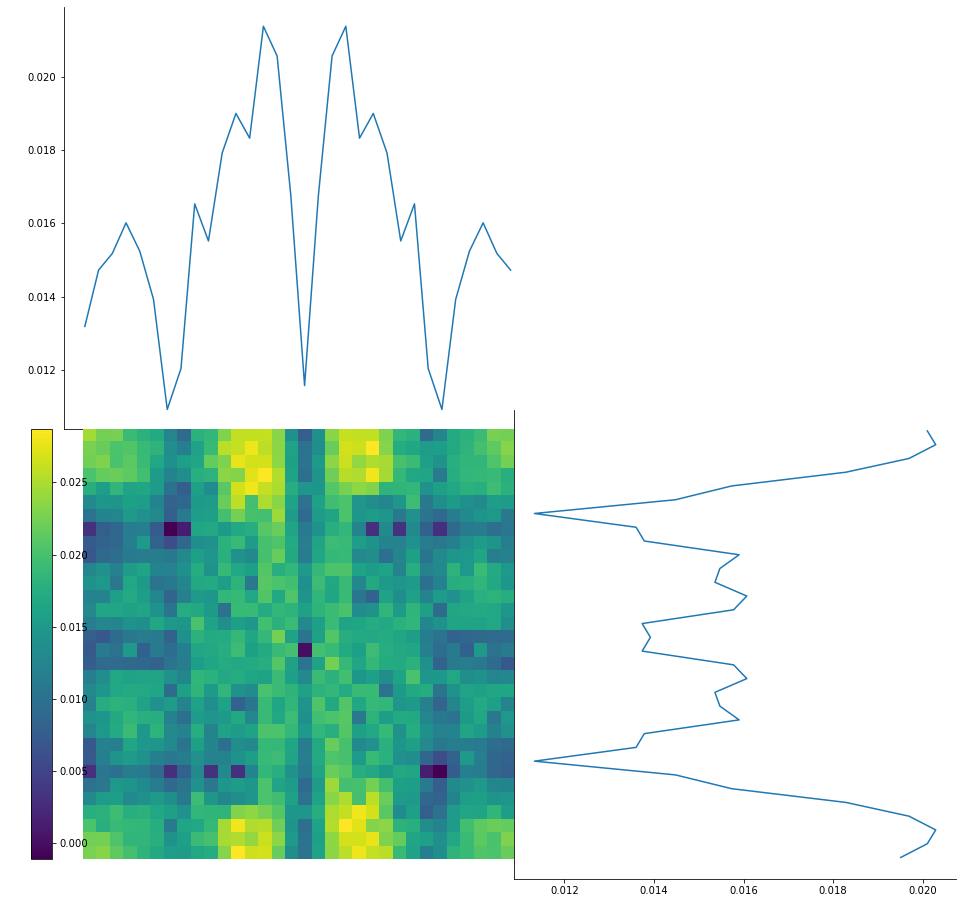

In [21]:
create_comparison_plot(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="SNGAN")

Text(0.5, 0.98, 'Comparison between Real and SN_bilinear - left: colomn wise right: row-wise')

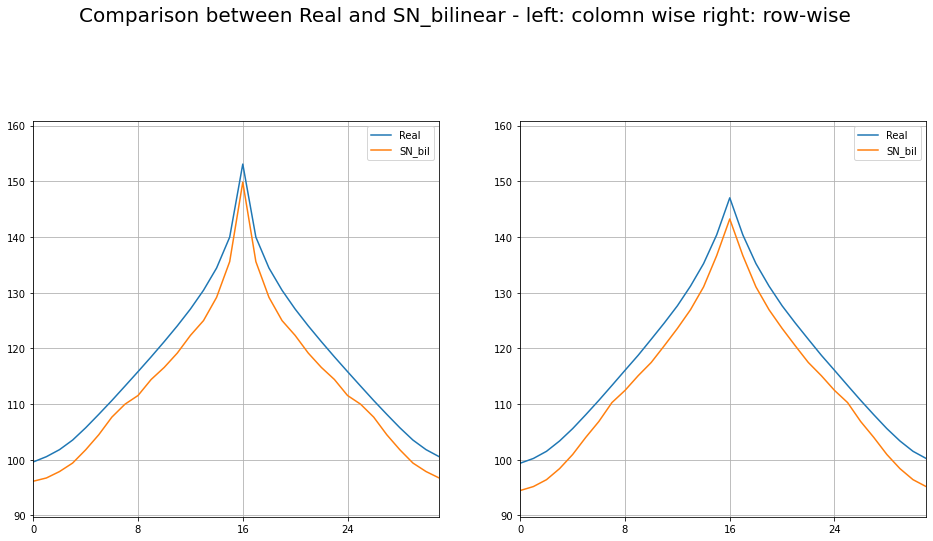

In [22]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.grid()
ax2.grid()
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g, label='SN_bil')
ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g, label='SN_bil')
ymin = min(min(zero_axis_r),min(zero_axis_g),min(one_axis_r),min(one_axis_g))
ymax = max(max(zero_axis_r),max(zero_axis_g),max(one_axis_r),max(one_axis_g))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real and SN_bilinear - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and SN_bilinear - left: colomn wise right: row-wise')

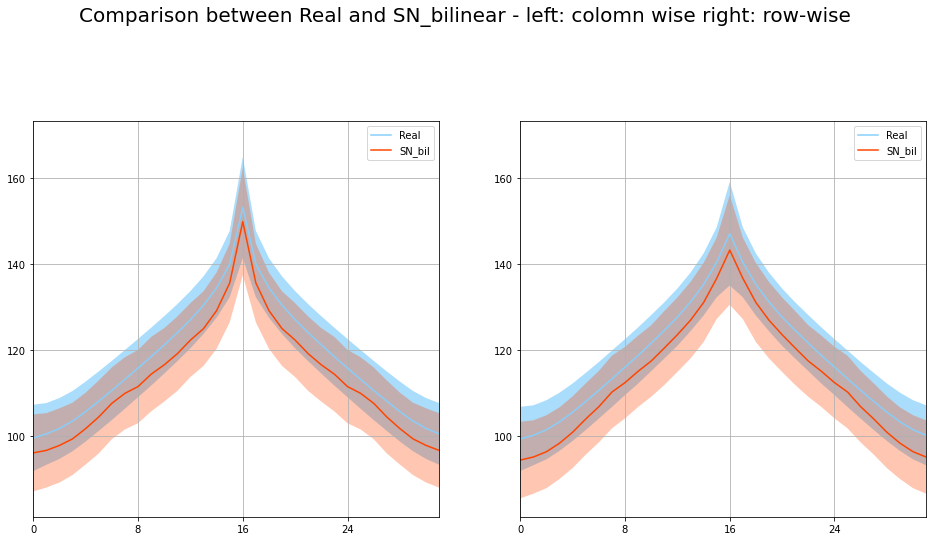

In [23]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_r)),zero_axis_g, label='SN_bil', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g + std_zero_axis_g, zero_axis_g -std_zero_axis_g,facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_g)),one_axis_g, label='SN_bil',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g + std_one_axis_g, one_axis_g -std_one_axis_g,facecolor='orangered', alpha=0.3)
leg = ax1.legend()
leg = ax2.legend()
ymin = min(min(zero_axis_r-std_zero_axis_r),min(zero_axis_g-std_zero_axis_g),min(one_axis_r-std_one_axis_r),min(one_axis_g-std_one_axis_g))
ymax = max(max(zero_axis_r+std_zero_axis_r),max(zero_axis_g+std_zero_axis_g),max(one_axis_r+std_one_axis_r),max(one_axis_g+std_one_axis_g))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and SN_bilinear - left: colomn wise right: row-wise", fontsize=20)

### Normalized

Text(0.5, 0.98, 'Comparison between Real and SN_bilinear - left: colomn wise right: row-wise')

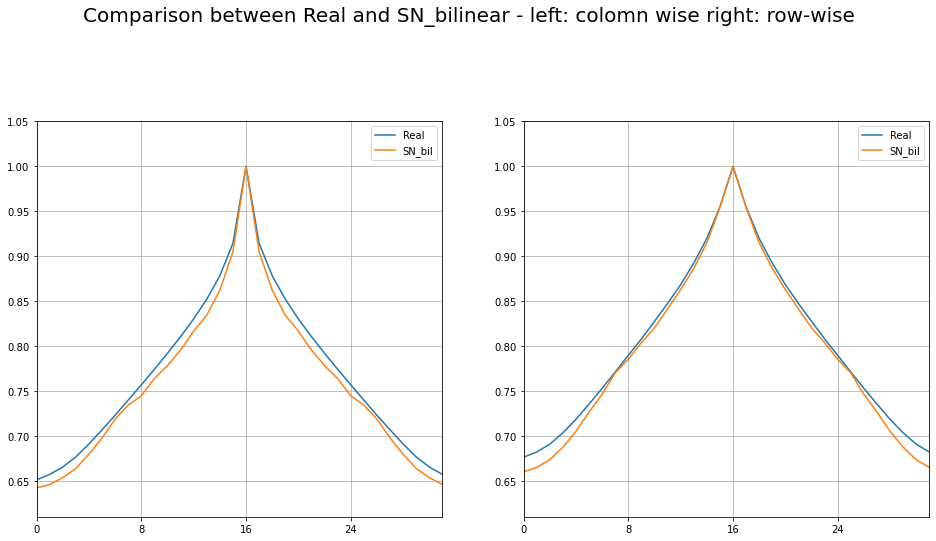

In [24]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g/zero_axis_g.max(), label='SN_bil')
ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='SN_bil')
ymin = min(min(zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max()))
ymax = max(max(zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max()))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and SN_bilinear - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and SN_bilinear - left: colomn wise right: row-wise')

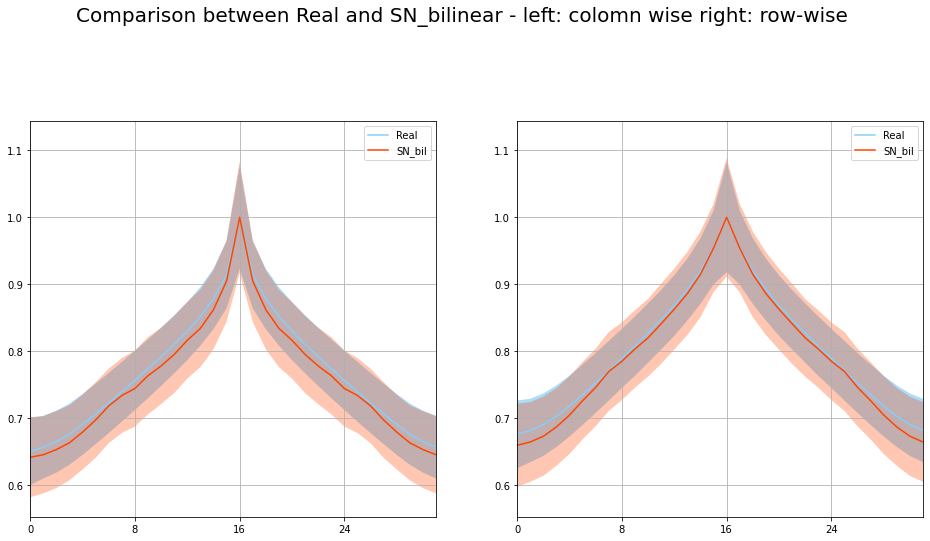

In [25]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r/zero_axis_r.max() + std_zero_axis_r/zero_axis_r.max(), zero_axis_r/zero_axis_r.max() -std_zero_axis_r/zero_axis_r.max(),facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_r)),zero_axis_g/zero_axis_g.max(), label='SN_bil', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g/zero_axis_g.max() + std_zero_axis_g/zero_axis_g.max(), zero_axis_g/zero_axis_g.max() -std_zero_axis_g/zero_axis_g.max(),facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r/one_axis_r.max() + std_one_axis_r/one_axis_r.max(), one_axis_r/one_axis_r.max() -std_one_axis_r/one_axis_r.max(),facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='SN_bil',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g/one_axis_g.max() + std_one_axis_g/one_axis_g.max(), one_axis_g/one_axis_g.max() -std_one_axis_g/one_axis_g.max(),facecolor='orangered', alpha=0.3)

ymin = min(min(zero_axis_r/zero_axis_r.max() -std_zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max() -std_zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max() -std_one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max() -std_one_axis_g/one_axis_g.max()))
ymax = max(max(zero_axis_r/zero_axis_r.max() + std_zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max() + std_zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max() + std_one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max() + std_one_axis_g/one_axis_g.max()))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and SN_bilinear - left: colomn wise right: row-wise", fontsize=20)

### Real vs Fake relative

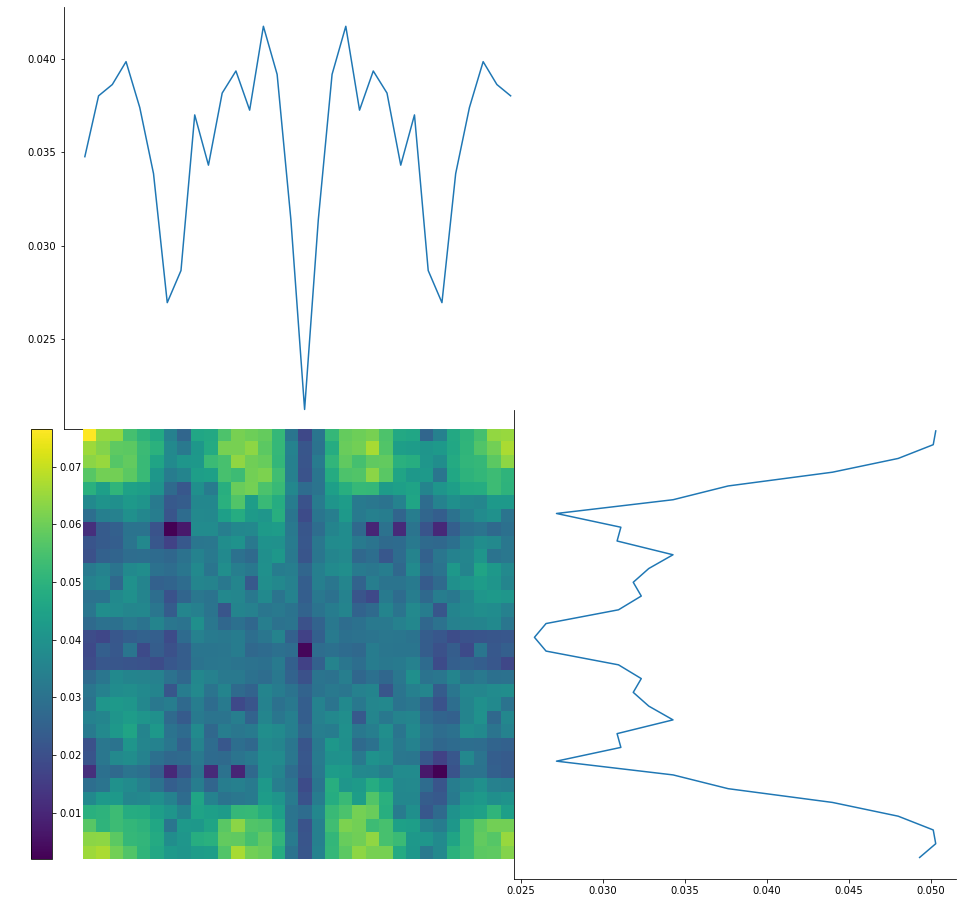

In [26]:
create_comparison_plot_rel(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="SN_bil")

## FID-Calucluations

In [27]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(real_img, fake_img):
    
    mu1 = real_img.mean(axis=0)
    sigma1 = cov(real_img, rowvar=False)
    mu2 = fake_img.mean(axis=0)
    sigma2 = cov(fake_img, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [28]:
real_img = []
for _ in tqdm(range(int(len(images_real)))):
    real_img.extend([np.array(fft(images_real[_])).flatten()])
real_img = np.array(real_img)
fake_img = []
for _ in tqdm(range(int(len(images_l)))):
    fake_img.extend([np.array(fft(images_l[_])).flatten()])
fake_img = np.array(fake_img)
print("FID: ", calculate_fid(real_img,fake_img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39936/39936 [00:07<00:00, 5241.05it/s]


FID:  26029.09926965859


### Normalized

In [29]:
real_img = []
for _ in tqdm(range(int(len(images_real)))):
    real_img.extend([np.array(fft(images_real[_])).flatten()]/np.array(fft(images_real[_])).flatten().max())
real_img = np.array(real_img)
fake_img = []
for _ in tqdm(range(int(len(images_l)))):
    fake_img.extend([np.array(fft(images_l[_])).flatten()]/np.array(fft(images_l[_])).flatten().max())
fake_img = np.array(fake_img)
print("FID: ", calculate_fid(real_img,fake_img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39936/39936 [00:16<00:00, 2470.33it/s]


FID:  0.42316294848942937


## Classify

### Real

In [30]:
classes = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/all_classified")
ordered_images = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images_sorted")

In [31]:
print(len(classes), len(ordered_images))

13260 13260


In [32]:
class_0 = []
class_1 = []
class_2 = []
class_3 = []
class_4 = []
class_5 = []
class_6 = []
class_7 = []
class_8 = []
class_9 = []



for i in range(len(classes)):
    if classes[i] == 0:
        class_0.append(ordered_images[i])
    elif classes[i] == 1:
        class_1.append(ordered_images[i])
    elif classes[i] == 2:
        class_2.append(ordered_images[i])
    elif classes[i] == 3:
        class_3.append(ordered_images[i])
    elif classes[i] == 4:
        class_4.append(ordered_images[i])
    elif classes[i] == 5:
        class_5.append(ordered_images[i])
    elif classes[i] == 6:
        class_6.append(ordered_images[i])
    elif classes[i] == 7:
        class_7.append(ordered_images[i])
    elif classes[i] == 8:
        class_8.append(ordered_images[i])
    elif classes[i] == 9:
        class_9.append(ordered_images[i])
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200


In [33]:
print(len(class_0),len(class_1),len(class_2),len(class_3),len(class_4),len(class_5),len(class_6),len(class_7),len(class_8),len(class_9))

1326 1136 1443 1299 1339 1076 1306 1309 1479 1547


Text(0.5, 0.98, 'Comparison between classes Real (Normalized) - left: colomn wise right: row-wise')

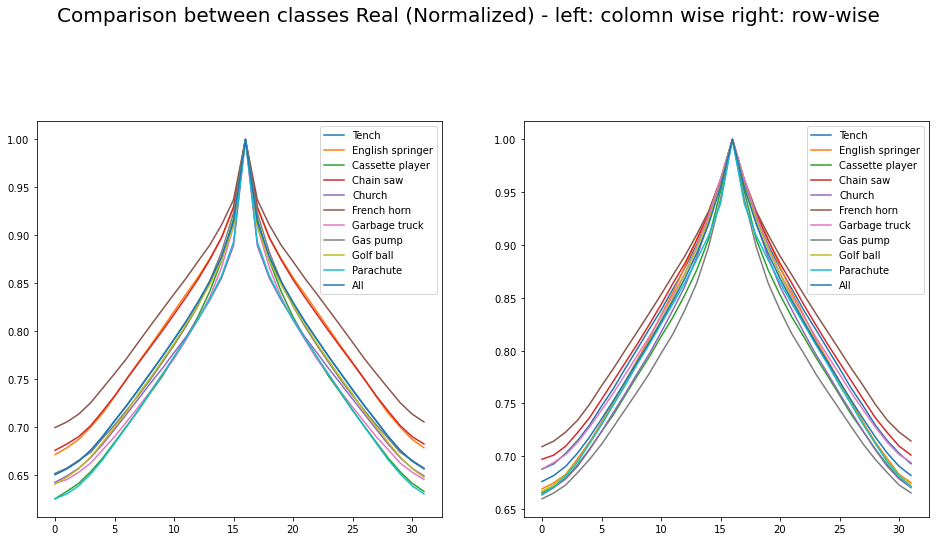

In [34]:
two_dim_0, zero_axis_0, one_axis_0, m_0, n_0,min_zero_axis_0,max_zero_axis_0, min_one_axis_0, max_one_axis_0, std_zero_axis_0, std_one_axis_0 = create_informations(class_0)
two_dim_1, zero_axis_1, one_axis_1, m_1, n_1,min_zero_axis_1,max_zero_axis_1, min_one_axis_1, max_one_axis_1, std_zero_axis_1, std_one_axis_1 = create_informations(class_1)
two_dim_2, zero_axis_2, one_axis_2, m_2, n_2,min_zero_axis_2,max_zero_axis_2, min_one_axis_2, max_one_axis_2, std_zero_axis_2, std_one_axis_2 = create_informations(class_2)
two_dim_3, zero_axis_3, one_axis_3, m_3, n_3,min_zero_axis_3,max_zero_axis_3, min_one_axis_3, max_one_axis_3, std_zero_axis_3, std_one_axis_3 = create_informations(class_3)
two_dim_4, zero_axis_4, one_axis_4, m_4, n_4,min_zero_axis_4,max_zero_axis_4, min_one_axis_4, max_one_axis_4, std_zero_axis_4, std_one_axis_4 = create_informations(class_4)
two_dim_5, zero_axis_5, one_axis_5, m_5, n_5,min_zero_axis_5,max_zero_axis_5, min_one_axis_5, max_one_axis_5, std_zero_axis_5, std_one_axis_5 = create_informations(class_5)
two_dim_6, zero_axis_6, one_axis_6, m_6, n_6,min_zero_axis_6,max_zero_axis_6, min_one_axis_6, max_one_axis_6, std_zero_axis_6, std_one_axis_6 = create_informations(class_6)
two_dim_7, zero_axis_7, one_axis_7, m_7, n_7,min_zero_axis_7,max_zero_axis_7, min_one_axis_7, max_one_axis_7, std_zero_axis_7, std_one_axis_7 = create_informations(class_7)
two_dim_8, zero_axis_8, one_axis_8, m_8, n_8,min_zero_axis_8,max_zero_axis_8, min_one_axis_8, max_one_axis_8, std_zero_axis_8, std_one_axis_8 = create_informations(class_8)
two_dim_9, zero_axis_9, one_axis_9, m_9, n_9,min_zero_axis_9,max_zero_axis_9, min_one_axis_9, max_one_axis_9, std_zero_axis_9, std_one_axis_9 = create_informations(class_9)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_0)),zero_axis_0/zero_axis_0.max(), label='Tench')
ax1.plot(range(len(zero_axis_1)),zero_axis_1/zero_axis_1.max(), label='English springer')
ax1.plot(range(len(zero_axis_2)),zero_axis_2/zero_axis_2.max(), label='Cassette player')
ax1.plot(range(len(zero_axis_3)),zero_axis_3/zero_axis_3.max(), label='Chain saw')
ax1.plot(range(len(zero_axis_4)),zero_axis_4/zero_axis_4.max(), label='Church')
ax1.plot(range(len(zero_axis_5)),zero_axis_5/zero_axis_5.max(), label='French horn')
ax1.plot(range(len(zero_axis_6)),zero_axis_6/zero_axis_6.max(), label='Garbage truck')
ax1.plot(range(len(zero_axis_7)),zero_axis_7/zero_axis_7.max(), label='Gas pump')
ax1.plot(range(len(zero_axis_8)),zero_axis_8/zero_axis_8.max(), label='Golf ball')
ax1.plot(range(len(zero_axis_9)),zero_axis_9/zero_axis_9.max(), label='Parachute')
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='All')


ax2.plot(range(len(one_axis_0)),one_axis_0/one_axis_0.max(), label='Tench')
ax2.plot(range(len(one_axis_1)),one_axis_1/one_axis_1.max(), label='English springer')
ax2.plot(range(len(one_axis_2)),one_axis_2/one_axis_2.max(), label='Cassette player')
ax2.plot(range(len(one_axis_3)),one_axis_3/one_axis_3.max(), label='Chain saw')
ax2.plot(range(len(one_axis_4)),one_axis_4/one_axis_4.max(), label='Church')
ax2.plot(range(len(one_axis_5)),one_axis_5/one_axis_5.max(), label='French horn')
ax2.plot(range(len(one_axis_6)),one_axis_6/one_axis_6.max(), label='Garbage truck')
ax2.plot(range(len(one_axis_7)),one_axis_7/one_axis_7.max(), label='Gas pump')
ax2.plot(range(len(one_axis_8)),one_axis_8/one_axis_8.max(), label='Golf ball')
ax2.plot(range(len(one_axis_9)),one_axis_9/one_axis_9.max(), label='Parachute')
ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='All')


leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between classes Real (Normalized) - left: colomn wise right: row-wise", fontsize=20)

### Generated

In [35]:
classes_g = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN/log/example/class_bilinear_SN/all_classified")
ordered_images_g = load_obj_real("/work/kabaeuer/AA_Experiment/bilinear_SN/log/example/class_bilinear_SN/imagenette_images_sorted")

In [36]:
print(len(classes_g), len(ordered_images_g))

39934 39934


In [37]:
class_0_g = []
class_1_g = []
class_2_g = []
class_3_g = []
class_4_g = []
class_5_g = []
class_6_g = []
class_7_g = []
class_8_g = []
class_9_g = []



for i in range(len(classes_g)):
    if classes_g[i] == 0:
        class_0_g.append(ordered_images_g[i])
    elif classes_g[i] == 1:
        class_1_g.append(ordered_images_g[i])
    elif classes_g[i] == 2:
        class_2_g.append(ordered_images_g[i])
    elif classes_g[i] == 3:
        class_3_g.append(ordered_images_g[i])
    elif classes_g[i] == 4:
        class_4_g.append(ordered_images_g[i])
    elif classes_g[i] == 5:
        class_5_g.append(ordered_images_g[i])
    elif classes_g[i] == 6:
        class_6_g.append(ordered_images_g[i])
    elif classes_g[i] == 7:
        class_7_g.append(ordered_images_g[i])
    elif classes_g[i] == 8:
        class_8_g.append(ordered_images_g[i])
    elif classes_g[i] == 9:
        class_9_g.append(ordered_images_g[i])

In [38]:
print(len(class_0_g),len(class_1_g),len(class_2_g),len(class_3_g),len(class_4_g),len(class_5_g),len(class_6_g),len(class_7_g),len(class_8_g),len(class_9_g))

1897 1092 5390 1159 2857 66 1324 425 15553 10171


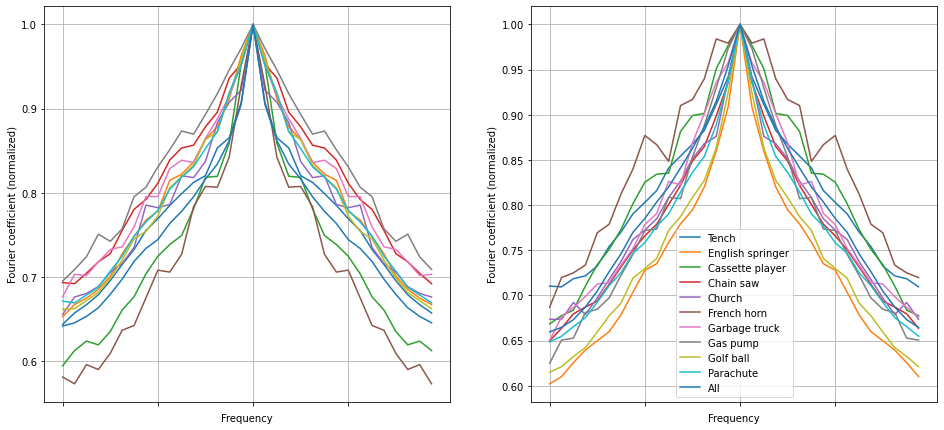

In [40]:
two_dim_0_g, zero_axis_0_g, one_axis_0_g, m_0_g, n_0_g,min_zero_axis_0_g,max_zero_axis_0_g, min_one_axis_0_g, max_one_axis_0_g, std_zero_axis_0_g, std_one_axis_0_g = create_informations(class_0_g)
two_dim_1_g, zero_axis_1_g, one_axis_1_g, m_1_g, n_1_g,min_zero_axis_1_g,max_zero_axis_1_g, min_one_axis_1_g, max_one_axis_1_g, std_zero_axis_1_g, std_one_axis_1_g = create_informations(class_1_g)
two_dim_2_g, zero_axis_2_g, one_axis_2_g, m_2_g, n_2_g,min_zero_axis_2_g,max_zero_axis_2_g, min_one_axis_2_g, max_one_axis_2_g, std_zero_axis_2_g, std_one_axis_2_g = create_informations(class_2_g)
two_dim_3_g, zero_axis_3_g, one_axis_3_g, m_3_g, n_3_g,min_zero_axis_3_g,max_zero_axis_3_g, min_one_axis_3_g, max_one_axis_3_g, std_zero_axis_3_g, std_one_axis_3_g = create_informations(class_3_g)
two_dim_4_g, zero_axis_4_g, one_axis_4_g, m_4_g, n_4_g,min_zero_axis_4_g,max_zero_axis_4_g, min_one_axis_4_g, max_one_axis_4_g, std_zero_axis_4_g, std_one_axis_4_g = create_informations(class_4_g)
two_dim_5_g, zero_axis_5_g, one_axis_5_g, m_5_g, n_5_g,min_zero_axis_5_g,max_zero_axis_5_g, min_one_axis_5_g, max_one_axis_5_g, std_zero_axis_5_g, std_one_axis_5_g = create_informations(class_5_g)
two_dim_6_g, zero_axis_6_g, one_axis_6_g, m_6_g, n_6_g,min_zero_axis_6_g,max_zero_axis_6_g, min_one_axis_6_g, max_one_axis_6_g, std_zero_axis_6_g, std_one_axis_6_g = create_informations(class_6_g)
two_dim_7_g, zero_axis_7_g, one_axis_7_g, m_7_g, n_7_g,min_zero_axis_7_g,max_zero_axis_7_g, min_one_axis_7_g, max_one_axis_7_g, std_zero_axis_7_g, std_one_axis_7_g = create_informations(class_7_g)
two_dim_8_g, zero_axis_8_g, one_axis_8_g, m_8_g, n_8_g,min_zero_axis_8_g,max_zero_axis_8_g, min_one_axis_8_g, max_one_axis_8_g, std_zero_axis_8_g, std_one_axis_8_g = create_informations(class_8_g)
two_dim_9_g, zero_axis_9_g, one_axis_9_g, m_9_g, n_9_g,min_zero_axis_9_g,max_zero_axis_9_g, min_one_axis_9_g, max_one_axis_9_g, std_zero_axis_9_g, std_one_axis_9_g = create_informations(class_9_g)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_0_g)),zero_axis_0_g/zero_axis_0_g.max(), label='Tench')
ax1.plot(range(len(zero_axis_1_g)),zero_axis_1_g/zero_axis_1_g.max(), label='English springer')
ax1.plot(range(len(zero_axis_2_g)),zero_axis_2_g/zero_axis_2_g.max(), label='Cassette player')
ax1.plot(range(len(zero_axis_3_g)),zero_axis_3_g/zero_axis_3_g.max(), label='Chain saw')
ax1.plot(range(len(zero_axis_4_g)),zero_axis_4_g/zero_axis_4_g.max(), label='Church')
ax1.plot(range(len(zero_axis_5_g)),zero_axis_5_g/zero_axis_5_g.max(), label='French horn')
ax1.plot(range(len(zero_axis_6_g)),zero_axis_6_g/zero_axis_6_g.max(), label='Garbage truck')
ax1.plot(range(len(zero_axis_7_g)),zero_axis_7_g/zero_axis_7_g.max(), label='Gas pump')
ax1.plot(range(len(zero_axis_8_g)),zero_axis_8_g/zero_axis_8_g.max(), label='Golf ball')
ax1.plot(range(len(zero_axis_9_g)),zero_axis_9_g/zero_axis_9_g.max(), label='Parachute')
ax1.plot(range(len(zero_axis_g)),zero_axis_g/zero_axis_g.max(), label='All')


ax2.plot(range(len(one_axis_0_g)),one_axis_0_g/one_axis_0_g.max(), label='Tench')
ax2.plot(range(len(one_axis_1_g)),one_axis_1_g/one_axis_1_g.max(), label='English springer')
ax2.plot(range(len(one_axis_2_g)),one_axis_2_g/one_axis_2_g.max(), label='Cassette player')
ax2.plot(range(len(one_axis_3_g)),one_axis_3_g/one_axis_3_g.max(), label='Chain saw')
ax2.plot(range(len(one_axis_4_g)),one_axis_4_g/one_axis_4_g.max(), label='Church')
ax2.plot(range(len(one_axis_5_g)),one_axis_5_g/one_axis_5_g.max(), label='French horn')
ax2.plot(range(len(one_axis_6_g)),one_axis_6_g/one_axis_6_g.max(), label='Garbage truck')
ax2.plot(range(len(one_axis_7_g)),one_axis_7_g/one_axis_7_g.max(), label='Gas pump')
ax2.plot(range(len(one_axis_8_g)),one_axis_8_g/one_axis_8_g.max(), label='Golf ball')
ax2.plot(range(len(one_axis_9_g)),one_axis_9_g/one_axis_9_g.max(), label='Parachute')
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='All')

ax1.grid()
ax2.grid()

ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])

#leg = ax1.legend()
leg = ax2.legend()
#fig.suptitle("Comparison between classes Generated(Normalized) - left: colomn wise right: row-wise", fontsize=20)